# Skin Color Estimation

In [1]:
from pathlib import Path
from pprint import pprint

import cv2 as cv
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from saac.utils import cv_imshow, color_show, quadrant_bboxes, crop_bbox
from saac.models import SkinColorMeanExtractor, SkinColorModeExtractor
from saac.image_analysis.process import ImageEqualizer, MidJourneyProcessor

## Sample Midjourney image

data\mj_raw\alocasia_a_community_health_worker_photorealistic_325f6686-ee76-4dba-b104-2db91382f57f.png


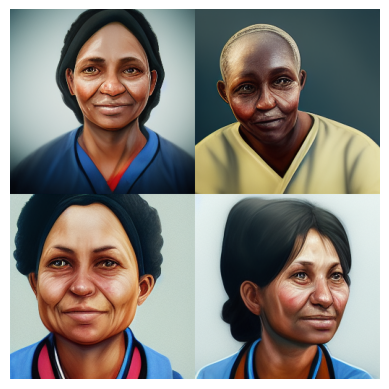

In [3]:
images_root = Path('./data/mj_raw')

img_path = list(images_root.glob('*.png'))[23]
print(img_path)

img_2x2 = cv.imread(str(img_path))
cv_imshow(img_2x2)

### Crop quadrant and get DeepFace predictions

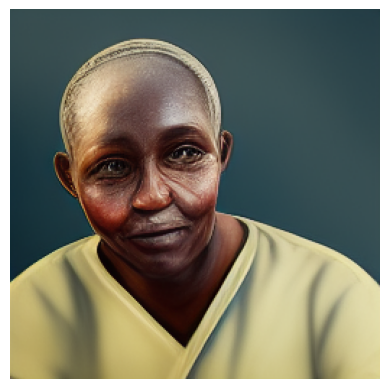

In [4]:
image = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[2])
cv_imshow(image)

C:\Dev\Anaconda3\envs\saac_dev\lib\site-packages\deepface\detectors\MtcnnWrapper.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Dev\\Anaconda3\\envs\\saac_dev\\lib\\site-packages\\mtcnn\\data\\mtcnn_weights.npy'>
  face_detector = MTCNN()


1/1 [==============================] - 1s 508ms/step
{'bbox': [47, 53, 152, 191],
 'gender': {'Man': 86.08391284942627, 'Woman': 13.916082680225372},
 'skin color': (104.44999999999999, 75.025, 73.25)}


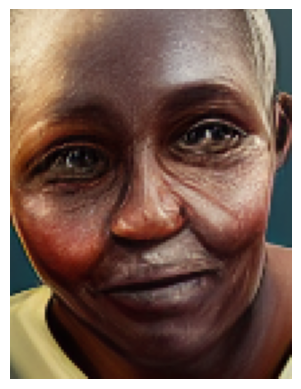

In [5]:
processor = MidJourneyProcessor()

preds = processor.image_predictions(image)
pprint(preds)
bbox = preds['bbox']
face = crop_bbox(image, bbox)
cv_imshow(face)

## Apply skin color extractors

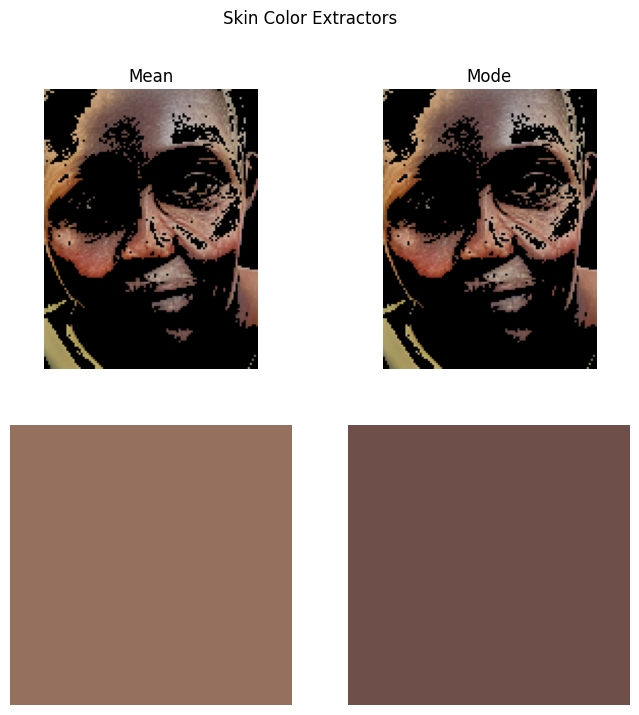

In [6]:
lower_quantile = 0.5
upper_quantile = 0.9
rgb_threshold = True
hist_bins = 25

mean_extractor = SkinColorMeanExtractor(
    lower_quantile=lower_quantile,
    upper_quantile=upper_quantile,
)

mode_extractor = SkinColorModeExtractor(
    lower_quantile=lower_quantile,
    upper_quantile=upper_quantile,
    hist_bins=hist_bins
)

mean_color, mean_mask = mean_extractor.extract(face)
mode_color, mode_mask = mode_extractor.extract(face)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

cv_imshow(face*mean_mask[:, :, np.newaxis], ax=ax[0,0])
color_show(mean_color, ax=ax[1, 0])
ax[0,0].set_title('Mean')

cv_imshow(face*mode_mask[:, :, np.newaxis], ax=ax[0,1])
color_show(mode_color, ax=ax[1, 1])
ax[0,1].set_title('Mode')

fig.suptitle('Skin Color Extractors');

## Apply image equalizer before extraction

Text(0.5, 1.0, 'Equalized')

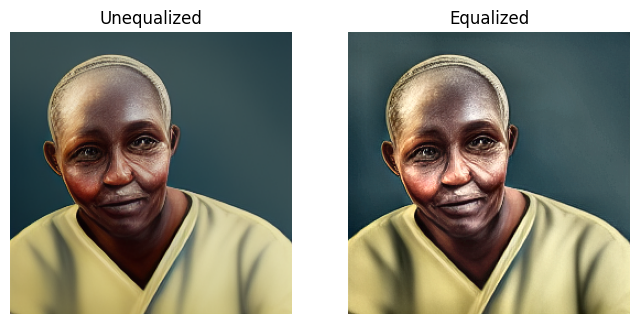

In [7]:
clip_limit = 2.0
grid_size = 8

equalizer = ImageEqualizer(
    clipLimit=clip_limit,
    grid_size=grid_size
)

image_cl = equalizer.equalize(image)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
                       
cv_imshow(image, ax=ax[0])
ax[0].set_title('Unequalized')

cv_imshow(image_cl, ax=ax[1])
ax[1].set_title('Equalized')

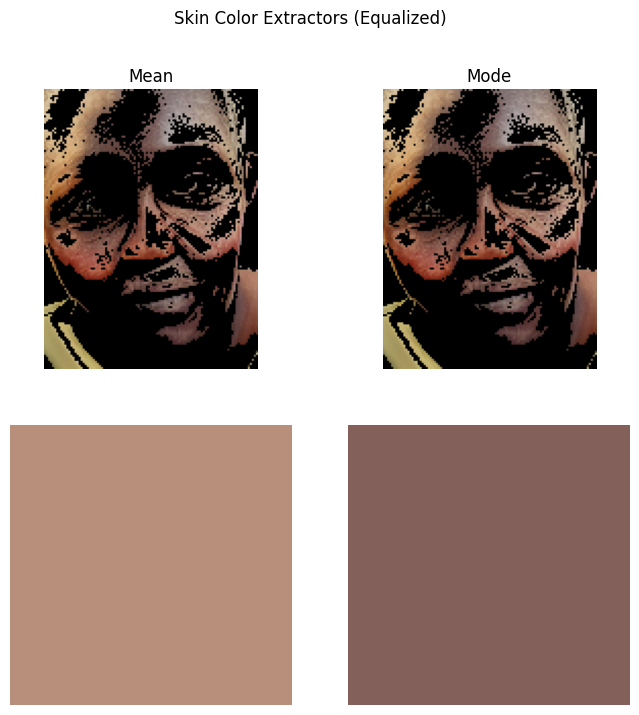

In [8]:
face_cl = crop_bbox(image_cl, bbox)

mean_color, mean_mask = mean_extractor.extract(face_cl)
mode_color, mode_mask = mode_extractor.extract(face_cl)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

cv_imshow(face*mean_mask[:, :, np.newaxis], ax=ax[0,0])
color_show(mean_color, ax=ax[1, 0])
ax[0,0].set_title('Mean')

cv_imshow(face*mode_mask[:, :, np.newaxis], ax=ax[0,1])
color_show(mode_color, ax=ax[1, 1])
ax[0,1].set_title('Mode')

fig.suptitle('Skin Color Extractors (Equalized)');